In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot

from networkx.drawing.nx_pydot import graphviz_layout
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D, IPythonConsole
from torch_geometric.transforms import Compose

from transform import OGBTransform, SkeletonTree
from utils.process import mol_from_data
from utils.peptides_functional import PeptidesFunctionalDataset

### Visualization

Load data

In [2]:
transform = Compose([OGBTransform(), SkeletonTree(mol=True, max_level=12)])
dataset = PeptidesFunctionalDataset(pre_transform=transform)

PeptidesFunctionalDataset has been updated.
Will you update the dataset now? (y/N)
y
Processing...
Converting SMILES strings into graphs...


100%|███████████████████████████████████████████████████████████████████████████| 15535/15535 [00:50<00:00, 307.49it/s]


Saving...
Done!


Display the original molecular graph *without* atom indices

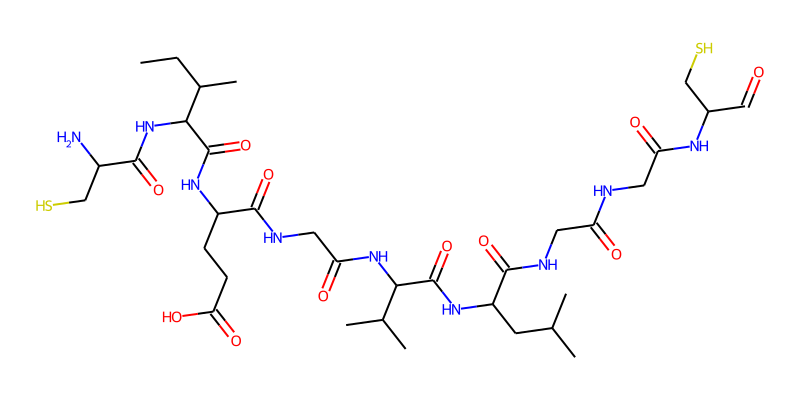

In [3]:
data = dataset[26]
mol = mol_from_data(data)

Draw.MolToImage(mol, size=(800, 400))#.save('mol.png')

Display the original molecular graph *with* atom indices

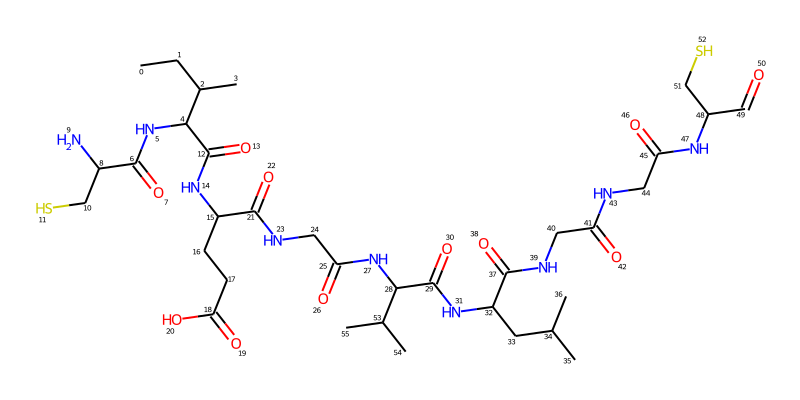

In [4]:
def show_atom_index(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol

Draw.MolToImage(show_atom_index(mol, 'atomNote'), size=(800, 400))

Color the original molecular graph, and show atom indices of trunks at various levels in the original molecular graph

In [5]:
hl_atoms = list()  # a list of atoms to be highlighted
hl_bonds = list()  # a list of bonds to be highlighted

colors = [(0,0.85,0), (0.48,0.78,0.95), (0.98,0.5,0.45)]  # green, light blue, and salmon
atom_colors = {}
bond_colors = {}

# loop in reverse level order, prioritizing the display of colors for lower-level trunks
for level, trunk in enumerate(reversed(data.trunk_list)):
    level = len(data.trunk_list) - 1 - level
    print(f'==================== Level {level} ====================')

    trunk_bags = list()  # a list of bags on the 'level'th-level trunk of the skeleton tree
    for t in trunk:
        trunk_bags.extend(t)
    # print(f'Trunk bags: {trunk_bags}')

    for bag in trunk_bags:
        for atom in data.bag_list[bag]:
            atom_colors[atom] = colors[level]  # the color for 'atom'
            if atom not in hl_atoms:
                hl_atoms.append(atom)

        for i in data.bag_list[bag]:
            for j in data.bag_list[bag]:
                bond = mol.GetBondBetweenAtoms(i, j)
                if bond:  # a bond exists between atoms 'i' and 'j'
                    bond_colors[bond.GetIdx()] = colors[level]  # the color for 'bond'
                    if bond.GetIdx() not in hl_bonds:
                        hl_bonds.append(bond.GetIdx())
    print(f'Highlighted atoms: {hl_atoms}')

==================== Level 2 ====================
Highlighted atoms: [2, 3, 18, 20, 34, 36, 53, 55]
==================== Level 1 ====================
Highlighted atoms: [2, 3, 18, 20, 34, 36, 53, 55, 4, 1, 0, 6, 7, 8, 9, 12, 13, 19, 17, 16, 15, 21, 22, 25, 26, 29, 30, 35, 33, 32, 37, 38, 41, 42, 45, 46, 51, 52, 48, 54, 28]
==================== Level 0 ====================
Highlighted atoms: [2, 3, 18, 20, 34, 36, 53, 55, 4, 1, 0, 6, 7, 8, 9, 12, 13, 19, 17, 16, 15, 21, 22, 25, 26, 29, 30, 35, 33, 32, 37, 38, 41, 42, 45, 46, 51, 52, 48, 54, 28, 49, 50, 47, 44, 43, 40, 39, 31, 27, 24, 23, 14, 5, 10, 11]


Visualize the trunks at various levels in the original molecular graph

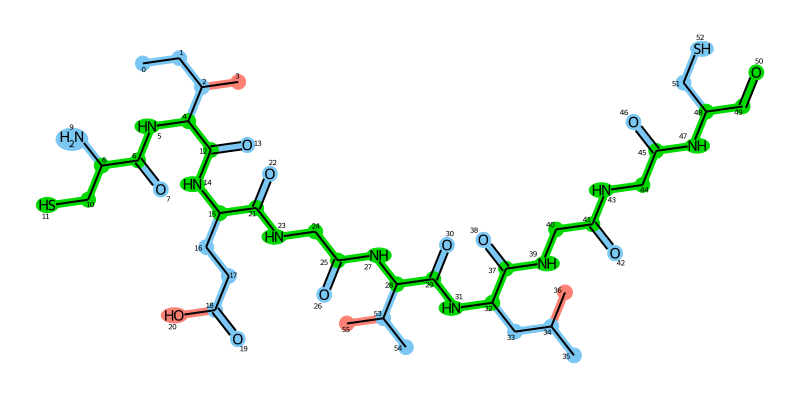

In [6]:
from IPython.display import Image

drawer = rdMolDraw2D.MolDraw2DCairo(800, 400)
drawer.drawOptions().useBWAtomPalette()
drawer.DrawMolecule(mol, highlightAtoms=hl_atoms, highlightAtomColors=atom_colors,
                    highlightBonds=hl_bonds, highlightBondColors=bond_colors)
drawer.FinishDrawing()
# drawer.WriteDrawingText('highlight.png')

pic = drawer.GetDrawingText()
Image(pic)

Color the skeleton tree, and show bag indices of trunks at various levels in the skeleton tree

In [7]:
colors = [(0,0.85,0), (0.48,0.78,0.95), (0.98,0.5,0.45)]  # green, light blue, and salmon
node_colors = {}
edge_colors = {}

# loop in reverse level order, prioritizing the display of colors for lower-level trunks
for level, trunk in enumerate(reversed(data.trunk_list)):
    level = len(data.trunk_list) - 1 - level
    print(f'==================== Level {level} ====================')

    trunk_bags = list()  # a list of bags on the 'level'th-level trunk of the skeleton tree
    for t in trunk:
        trunk_bags.extend(t)
        for i in range(len(t)-1):
            node_colors[t[i]] = colors[level]
            edge_colors[(t[i], t[i+1])] = colors[level]
            edge_colors[(t[i+1], t[i])] = colors[level]
        node_colors[t[-1]] = colors[level]
    print(f'Trunk bags: {trunk_bags}')

==================== Level 2 ====================
Trunk bags: [55, 2, 61, 19, 67, 35, 72, 54]
==================== Level 1 ====================
Trunk bags: [56, 3, 55, 1, 0, 6, 57, 58, 8, 12, 59, 18, 61, 17, 16, 15, 60, 62, 21, 63, 25, 29, 65, 34, 67, 33, 32, 66, 37, 68, 69, 41, 70, 45, 51, 50, 71, 53, 72, 52, 64]
==================== Level 0 ====================
Trunk bags: [49, 48, 71, 47, 46, 70, 44, 43, 42, 69, 40, 39, 38, 68, 36, 66, 31, 30, 65, 28, 64, 27, 26, 63, 24, 23, 22, 62, 20, 60, 14, 13, 59, 11, 56, 4, 5, 57, 7, 58, 9, 10]


Visualize the trunks at various levels in the skeleton tree

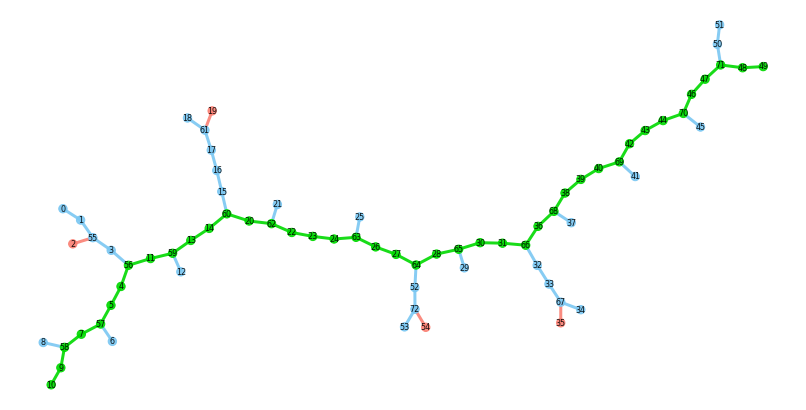

In [8]:
G = nx.Graph()
G.add_nodes_from(range(data.num_bags.item()))
G.add_edges_from(data.tree_edge_index.T.tolist())

plt.figure(figsize=(11, 5.5))
pos = graphviz_layout(G, prog='neato')
nx.draw(G, pos, with_labels=True, node_size=70, alpha=0.9, width=3, font_size=8,
        node_color=[node_colors[node] for node in G.nodes()],
        edge_color=[edge_colors[edge] for edge in G.edges()])
# plt.savefig('tree.png', bbox_inches='tight', format='png', dpi=200)
plt.show()